# Spotify 'Like' Predictor Project

By: Susan Kight

## Introduction/Problem Statement

Spotify, the largest on-demand music service in the world leverages big data and artificial learning to deliver a unique and personalized music listening experience. Spotify offers recommended playlists from tracks users are already familiar with, a 'Discover' tab that includes a customized playlist of new tracks, and an 'Insights' page where they list important findings or interesting insights derived from the data. 

With the vasts amounts of data that Spotify has available, users can download their music listening data to see what is stored and to use as they wish. As a result, I will be leveraging this data to make predictions.

## Project Goal

**Predict whether a Spotify user will 'Like' a track based on a number of song variables.**

Using a dataset consisting of music listening history for a particular Spotify user where each track is labeled '1' or '0' (**'Like'** or **not 'Like'**) will be used to develop and train a classification model that predicts whether a unseen track would be a 'Like' or not.

## Part 1 - Accessing and Storing the Data

### Data Source

Utilizing the [Spotify API](https://developer.spotify.com/documentation/web-api/) and the [Spotify library](https://spotipy.readthedocs.io/en/2.13.0/), accessing user data is relatively easy and deletes the need for software such as Postman or others to place requests.

In order to gain access to a user's data, API keys were generated using spotify's developer dashboard, available [here](https://developer.spotify.com/). Using these API keys, the Spotify library makes it very easy to pass these credentials into OAUTH to receive a token. Specifying the level of access as 'user-library-read' allows the python endpoint to read the user data and not make any changes to playlists or control the user's activity, such as pausing and playing music. 

**Note**:
The following code will not run unless you enter your own generated 'username', 'client_id', 'client_secret', and 'redirect_uri'. This can be done [here](https://developer.spotify.com/dashboard/login).

The flow of the code is as follows:
* Get token and authorize using Spotify.
* Get a list of playlist IDs to select which playlists to focus on. Two playlists were selected: a 'master' playlist of tracks in a genre, and a second, smaller playlist of tracks in which the user 'Liked' from that playlist.
* Perform audio analysis on the contained tracks, which generates attributes such as danceability, loudness, and liveness. Please note, the full list of variables is shared in a section below.
* Create new column, with value of 0 for tracks in the genre, and 1 for tracks in which the user liked using pandas.
* Append the two dataframes and delete duplicates, leaving the second occurance, which is the 'Liked' occurance.
* Output the appended dataframe to CSV for the purposes of this check-in as well as for purposes of distribution to the entire team.

<u> Code used:</u>

In [ ]:
import spotipy.util as util
import spotipy
import sys
import json
import pandas as pd
import numpy as np

#Get token and authorize
username = 'XXX'
client_id ='XXX'
client_secret = 'XXX'
redirect_uri = 'XXX'
scope = 'user-library-read'

token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)
sp = spotipy.Spotify(auth=token)


#Get Playlist IDs
playlists = sp.user_playlists(username)
for playlist in playlists['items']:
    playids = [playlist['id']]
    print(playids)
    
    
#Define analyze tracks
def analyze_playlist(username, playlist_id):
    
    # Create empty dataframe
    playlist_features_list = ["artist","album","track_name",  "track_id","danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    # Loop through every track in the playlist, extract features and append the features to the playlist df
    
    playlist = sp.user_playlist_tracks(username, playlist_id, limit = 100)["items"]
    for track in playlist:
        # Create empty dict
        playlist_features = {}
        # Get metadata
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        
        # Get audio features
        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[4:]:
            playlist_features[feature] = audio_features[feature]
        
        # Concat the dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
        
    return playlist_df

#Analyze big playlist
posthardcore = analyze_playlist(username, '3dgfLqrR0v70pKNb961q6q')
#Add 0 for not favorite
posthardcore['Fave'] = 0
#Check for NaN
posthardcore.isnull().values.any()


#Analyze favorite playlist
faves = analyze_playlist(username, '6X57II2enZV2IIkGLjhYvA')
#Add 1 for  favorite
faves['Fave'] = 1
#Check for NaN
faves.isnull().values.any()

#Append faves to end of posthardcore
Library = posthardcore.append(faves, ignore_index = True)
#Delete diplicates, leaving those from 'faves' dataset
Library.drop_duplicates(subset = ['track_name'], keep = 'last')

#Library to CSV
Library.to_csv("Library.csv", index = False)

Through the 'analyze_playlist' function, a pandas dataframe is created that contains the audio analytics of the two playlists with only pertainent measures and metrics.

The output of the above code is 1 CSV file:

- Library

Please note, in the above code, a simple 'df.isnull().values.any()' was used to check for null values to ensure if anything was present that they could be handled prior to performing deeper analysis and modelling.

### Variable Defintions

The variables included within the dataset are:

- Artist: The Name of the Artist.
- Album: The Name of the Album that the track is on.
- Track: The Name of the track.
- Track_id: Unique identifier for the track.
- danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 
- Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. 
- Key: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. 
- Loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). 
- Mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- Speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 
- Instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. The distribution of values for this feature look like this:
- Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 
- Duration_ms: Duration of track in milliseconds
- Time_signature: 	An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- Fave: This is the target variable for the track. It can be either '0' or '1'. '1' implies that this track will be set to 'Like' by the Spotify user. '0' implies that the track will **not** be set to a 'Like'.

## Part 2 - Data Exploration, Transformation and Predictive Modeling 

In the part 1, I discussed at length the data source and shared the code used to pull the data, performed initial data analysis for data cleaning, as well as provided definitions for each of the variables and the target.

In this part 2, I will explore the data and perform analysis to better understand it and the relationships between each variable, perform data visualizations, and train and test a classification model reviewing its accuracy.

The model will then be used to build a flask application to perform predictions on new unseen data.

### Data Load for Analysis

In [1]:
import os
import pandas as pd   
import numpy as np
import statistics 

#import the CSV file
filepath=os.path.join(os.getcwd(), 'data', 'Library.csv')
df = pd.read_csv(filepath)

#view first 10 rows
df.head(10)

artist                                          album  \
0  Bring Me The Horizon  That's The Spirit (Track by Track Commentary)   
1             Movements                                 Feel Something   
2           Picturesque                              Back to Beautiful   
3  Bring Me The Horizon                                            amo   
4     Dance Gavin Dance                          Instant Gratification   
5               Emarosa                                            131   
6       Hometown Losers                                         Divine   
7           Picturesque                                           Pray   
8        The Word Alive                                  Violent Noise   
9               Emarosa                                     Peach Club   

         track_name                track_id  danceability  energy  key  \
0       Drown - New  1RgPtXc8AmD8XlmP0IuBr4         0.405   0.945    1   
1       Full Circle  4pdPJQqQNWuDQ6Swl2mW2u         0.554   0.832    4   
2       Unannounced  7iovNu2YJixCz3fFn2Fv7u         0.345   0.963    4   
3       in the dark  4swVflM7KtMxzfHBWqPv9S         0.535   0.768    6   
4  We Own The Night  4rc2WNOt2w8BHfQjBC8PO0         0.224   0.905    5   
5           Cloud 9  2vRZcqelOdc9rXSyidYxM4         0.273   0.952   11   
6            Divine  3sIIjl9dfTGXIIfTZYaAV7         0.516   0.963   10   
7              Pray  1DuYS5IWAl7fk4sottVMyZ         0.553   0.818    4   
8        Red Clouds  1N54Dn1u4LmQOhRPIg9Rii         0.482   0.949    8   
9      Help You Out  6zFeOnTt1bYfhdKyrXXuK3         0.628   0.924    1   

   loudness  mode  speechiness  instrumentalness  liveness  valence    tempo  \
0    -3.130     0       0.0812          0.000043    0.7460    0.229  143.145   
1    -5.536     1       0.0306          0.003100    0.1180    0.674  160.087   
2    -3.966     0       0.3390          0.004410    0.1840    0.223  147.991   
3    -4.554     0       0.0577          0.000000    0.6610    0.514  156.014   
4    -3.239     0       0.0722          0.000000    0.2810    0.485   78.318   
5    -2.681     0       0.0778          0.000000    0.2050    0.626  167.835   
6    -3.507     1       0.0818          0.000131    0.2230    0.368  145.053   
7    -4.988     0       0.0442          0.000003    0.1440    0.145  119.908   
8    -4.028     0       0.0906          0.000020    0.0826    0.303  116.038   
9    -4.259     0       0.0291          0.000014    0.0656    0.382  112.060   

   duration_ms  time_signature  Fave  
0       222107               4     0  
1       204787               4     0  
2       223413               4     0  
3       271187               4     0  
4       205707               4     0  
5       215971               4     0  
6       157284               4     0  
7       224453               4     0  
8       233120               4     0  
9       222933               4     0

### Data Exploration

In [2]:
df.shape 

(250, 17)

The dataset being used has 250 rows and 17 columns which will be explored and a decision made as to which variables to leverage for the predictive classification model.

In [3]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            250 non-null    object 
 1   album             250 non-null    object 
 2   track_name        250 non-null    object 
 3   track_id          250 non-null    object 
 4   danceability      250 non-null    float64
 5   energy            250 non-null    float64
 6   key               250 non-null    int64  
 7   loudness          250 non-null    float64
 8   mode              250 non-null    int64  
 9   speechiness       250 non-null    float64
 10  instrumentalness  250 non-null    float64
 11  liveness          250 non-null    float64
 12  valence           250 non-null    float64
 13  tempo             250 non-null    float64
 14  duration_ms       250 non-null    int64  
 15  time_signature    250 non-null    int64  
 16  Fave              250 non-null    int64  
dt

The above output provides key information on the data types for each of the columns/variables. 

- There are no null values that exist in any of the columns/variables
- artist, album, track_name, and track_id are all recognized as objects as they contain characters. They are similar to unique identifiers within the dataset and as a result the distribution of these variable will not be explored as each observation has a unique value. This will be ignored when modeling
- All numerical variables are identified correctly where they are integer or floating-point numbers. 
- Fave is the binary target of 0 or 1, is recognized as an integer. 
- mode is a categorical variable with only value 0 or 1, so keeping it as an integer is best for the predictive model to work with.

#### Distributions of Data & Summary Statistics
Next, the distributions of each of the **indepedent variables** were explored by studying the values as well as the respective box plots for their distributions.

In [4]:
df.describe() 

danceability      energy         key    loudness        mode  \
count    250.000000  250.000000  250.000000  250.000000  250.000000   
mean       0.453780    0.874852    4.988000   -4.692588    0.520000   
std        0.099456    0.126636    3.359913    1.768260    0.500602   
min        0.125000    0.367000    0.000000  -12.855000    0.000000   
25%        0.392000    0.837500    2.000000   -5.608500    0.000000   
50%        0.458000    0.921500    5.000000   -4.279000    1.000000   
75%        0.527250    0.953000    8.000000   -3.486750    1.000000   
max        0.683000    0.996000   11.000000   -1.067000    1.000000   

       speechiness  instrumentalness    liveness     valence       tempo  \
count   250.000000        250.000000  250.000000  250.000000  250.000000   
mean      0.082186          0.037156    0.213724    0.411163  134.652652   
std       0.056385          0.142357    0.161001    0.173844   30.808756   
min       0.025500          0.000000    0.041300    0.049400   75.006000   
25%       0.043000          0.000000    0.108000    0.285000  107.996750   
50%       0.062350          0.000018    0.154500    0.393000  137.519500   
75%       0.103000          0.001548    0.274000    0.521250  156.619000   
max       0.339000          0.889000    0.878000    0.923000  195.992000   

         duration_ms  time_signature        Fave  
count     250.000000      250.000000  250.000000  
mean   221570.956000        3.940000    0.172000  
std     33669.712472        0.237963    0.378137  
min    145207.000000        3.000000    0.000000  
25%    203249.000000        4.000000    0.000000  
50%    222164.000000        4.000000    0.000000  
75%    234771.500000        4.000000    0.000000  
max    331250.000000        4.000000    1.000000

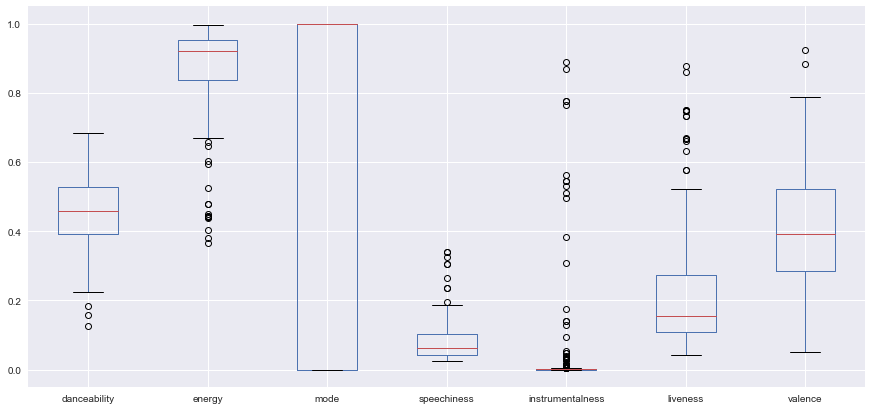

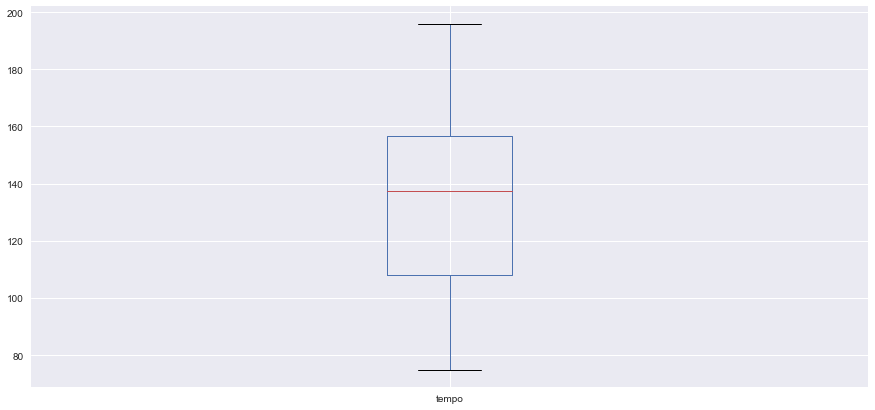

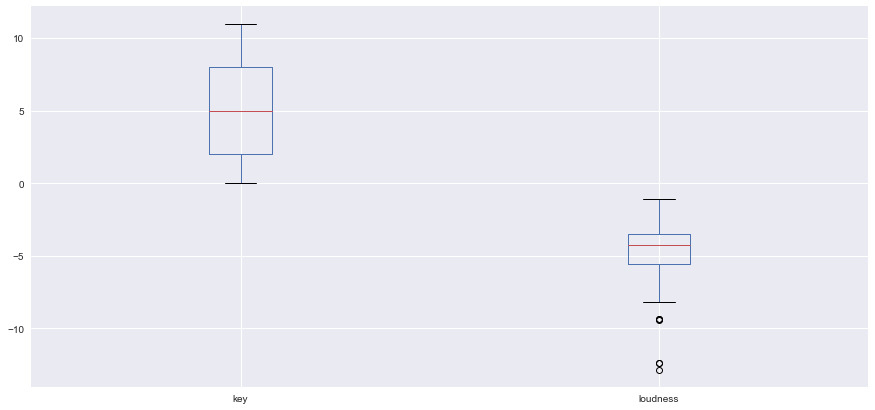

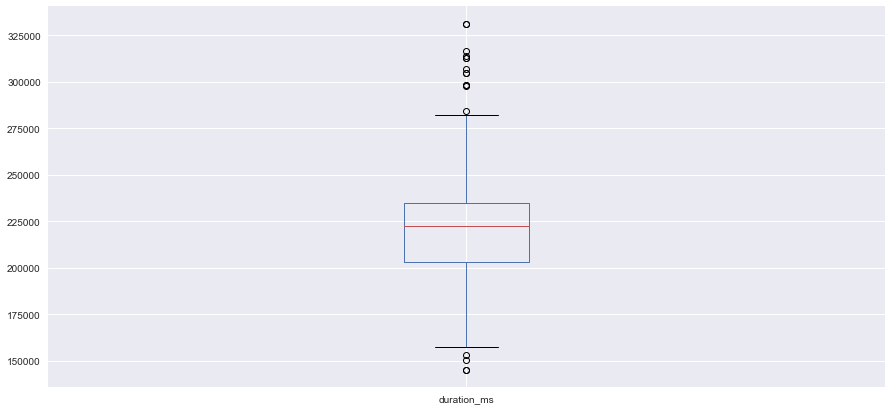

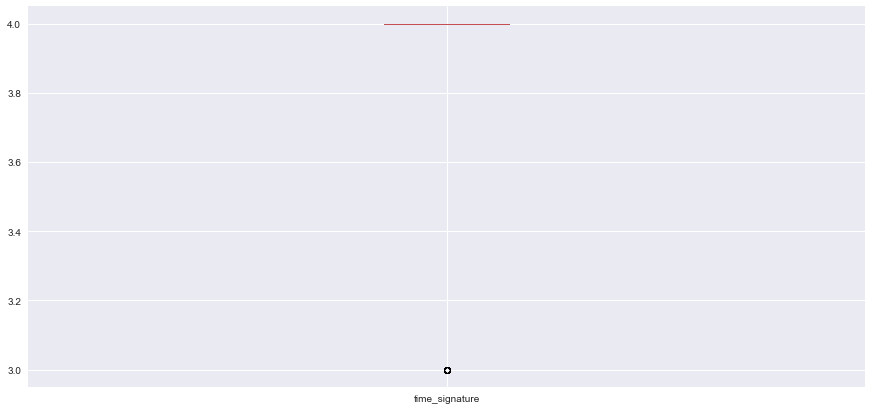

In [5]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

#boxplots for each variable
df[["danceability","energy","mode","speechiness","instrumentalness","liveness","valence"]].plot(kind="box", grid=True, figsize=(15,7)) 
df[["tempo"]].plot(kind="box", grid=True, figsize=(15,7)) 
df[["key","loudness"]].plot(kind="box", grid=True, figsize=(15,7)) 
df[["duration_ms"]].plot(kind="box", grid=True, figsize=(15,7)) 
df[["time_signature"]].plot(kind="box", grid=True, figsize=(15,7)) 
plt.show() 

The above output shows a set of summary statistics for each column/variable to help understand their respective distributions. 

- *danceability* - has a small number of outliers by the lower extreme. The red median line from boxplot appears to be close to the mean value displayed in the summary statistics table. I expect this to be close to a normal distribution. 
- *energy* - this has several outliers that are by the lower extreme which may need to be handled before moving to the modeling stage as this could have a bimodal distribution. As the median is higher than the mean it suggests a skewed distribution to the left which may need to be transformed by log to normalize the data. I will review this in detail during the histogram plots.
- *mode* - this is a categorical numeric variable with only 2 values 0 or 1 which is why the box plot interquartile range looks as it does.  
- *speechiness* - this has a small number of outliers by the upper extreme, with the median being significantly lower than the mean it suggests a skewed distribution and will need to be explored in case any transformations are required. I will also review this in further detail during the histogram plots.
- *instrumentalness* - There are several issues with outliers that will need to be determined whether those values are accurate and should remain as-is or if they should be handled in any way. The median is much smaller than the mean suggesting there could be an issue with a right-skewed distribution that may require transforming. I will review this in detail during the histogram plots.
- *liveness* - the distribution is displaying outliers and possibly bimodal. There is a skewed distribution to the right as the median is lower than the mean. I will review this in detail during the histogram plots.
- *valence* - this has more of a normal distribution and very few outliers exist. 
- *tempo* - similar to valence, except this is not showing and outliers. The mean and median values are fairly close suggesting a normal distribution.
- *key* - not outliers for this data
- *loudness* - There are some outliers but nothing too significant. There appears to have a left skew and may need to be transformed before using in the model. I will review this in detail during the histogram plots.
- *duration_ms* - has a small number of observations that are outliers and longer in length at the upper extremes. The mean and median are similar values suggesting a possible normal distribution.
- *time_signature* - The min and max values together with the box plot suggest there isn't much distribution in the observations. 

#### Data Visualizations

Next, histrograms, scatterplots and heatmaps of correlation will be explored.


In [6]:
import plotly.offline as plyo 
import cufflinks as cf 

#interative histograms for each variable
plyo.init_notebook_mode() 
plyo.iplot( 
    df[["danceability","energy","key","loudness","mode","speechiness","instrumentalness","liveness","valence","tempo", "duration_ms", "time_signature"]].iplot(asFigure=True 
                                          ,kind='hist' 
                                          ,subplots=True 
                                          ,bins=10)) 



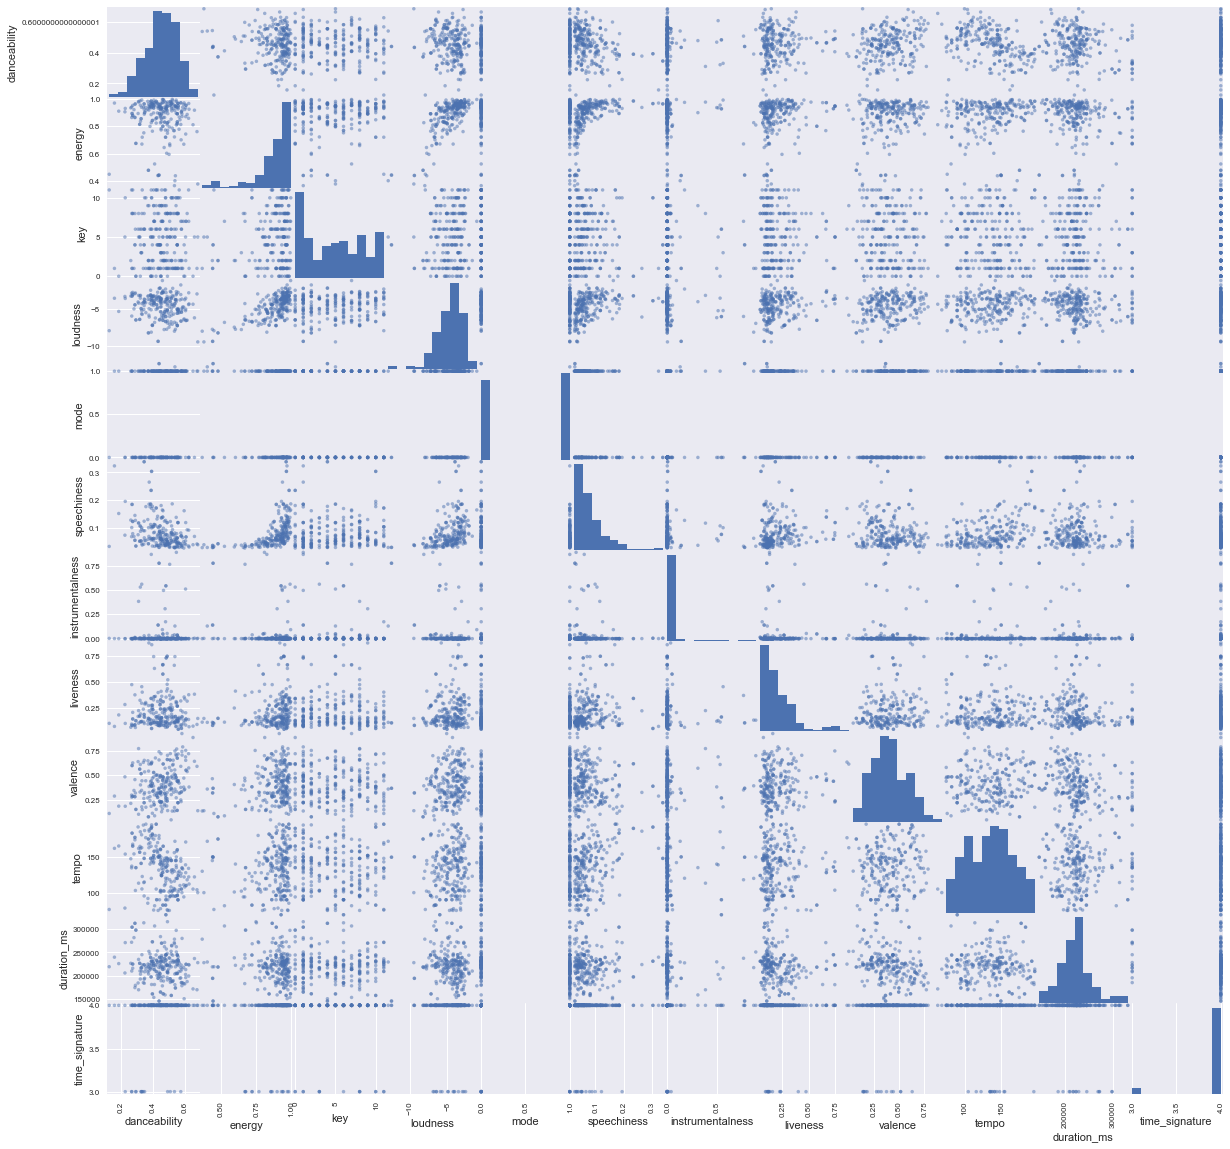

In [7]:
#scatterplot matrix of all variables
pd.plotting.scatter_matrix(df[["danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms", "time_signature"]], figsize=(20,20), diagonal="hist")
plt.show()

In [8]:
#correlation matrix
df[["danceability","energy","key","loudness","mode","speechiness","instrumentalness","liveness","valence","tempo", "duration_ms"]].corr()  

danceability    energy       key  loudness      mode  \
danceability          1.000000 -0.040134 -0.030006 -0.133523  0.133627   
energy               -0.040134  1.000000  0.122143  0.759994 -0.032230   
key                  -0.030006  0.122143  1.000000  0.093549 -0.129986   
loudness             -0.133523  0.759994  0.093549  1.000000  0.011961   
mode                  0.133627 -0.032230 -0.129986  0.011961  1.000000   
speechiness          -0.369433  0.461080  0.018035  0.367057 -0.158198   
instrumentalness     -0.001893 -0.180787 -0.072614 -0.337389 -0.125212   
liveness              0.018122  0.195035  0.006882  0.165774 -0.079694   
valence               0.253475  0.222571 -0.058886  0.200115  0.317921   
tempo                -0.398354  0.099265 -0.107635  0.055559  0.037883   
duration_ms          -0.150195 -0.088456 -0.009633 -0.081697 -0.264174   

                  speechiness  instrumentalness  liveness   valence     tempo  \
danceability        -0.369433         -0.001893  0.018122  0.253475 -0.398354   
energy               0.461080         -0.180787  0.195035  0.222571  0.099265   
key                  0.018035         -0.072614  0.006882 -0.058886 -0.107635   
loudness             0.367057         -0.337389  0.165774  0.200115  0.055559   
mode                -0.158198         -0.125212 -0.079694  0.317921  0.037883   
speechiness          1.000000         -0.106575  0.079671 -0.138121  0.376430   
instrumentalness    -0.106575          1.000000 -0.057872  0.030356 -0.001704   
liveness             0.079671         -0.057872  1.000000  0.073134  0.012768   
valence             -0.138121          0.030356  0.073134  1.000000  0.060971   
tempo                0.376430         -0.001704  0.012768  0.060971  1.000000   
duration_ms          0.006648         -0.028445 -0.109802 -0.310293 -0.033477   

                  duration_ms  
danceability        -0.150195  
energy              -0.088456  
key                 -0.009633  
loudness            -0.081697  
mode                -0.264174  
speechiness          0.006648  
instrumentalness    -0.028445  
liveness            -0.109802  
valence             -0.310293  
tempo               -0.033477  
duration_ms          1.000000

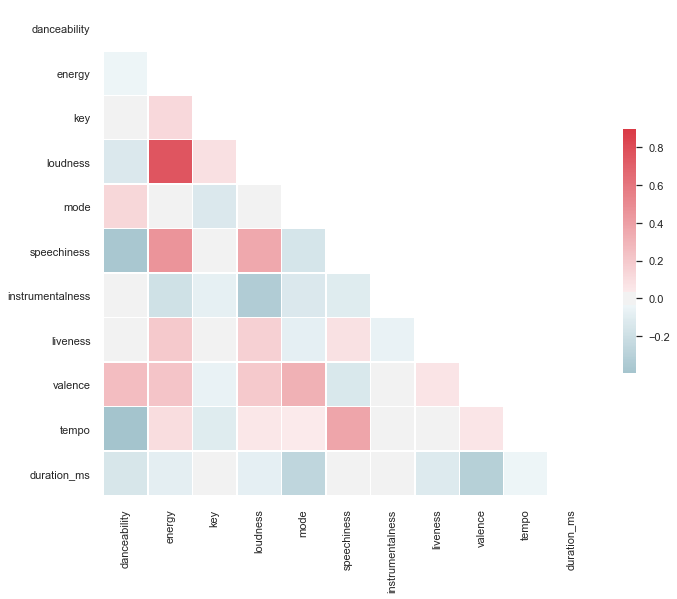

In [9]:
#Heatmap correlation plot with user defined function
import seaborn as sns
import matplotlib.pyplot as plt

def createCorrelationPlot(df): 
    sns.set(style="white") 
 
    f, ax = plt.subplots(figsize=(11, 9)) 
   
    sns.heatmap(df.corr() 
                ,mask=np.triu(np.ones_like(df.corr(), dtype=np.bool)) 
                ,cmap=sns.diverging_palette(220, 10, as_cmap=True) 
                ,vmax=.9, center=0 
                ,square=True, linewidths=.5, cbar_kws={"shrink": .5}) 
    plt.show() 

createCorrelationPlot(df[["danceability","energy","key","loudness","mode","speechiness","instrumentalness","liveness","valence","tempo", "duration_ms"]]) 

With the scatterplot, correlation matrix values and heatmap for the correlation, the relationships between variables can be easily understood. Some key findings include:

- Loudness and energy are strongly positively correlated as you would expect. Loudness and instrumentalness also have a strong negative correlation.
- Tempo and danceability are strongly negatively correlated which makes logical sense as slower paced tracks are still popular to dance to. Tempo is strongly positively correlated to speechiness as typically you do find the faster the tempo there is likelihood of high presence of spoken words in a track
- Danceability has the strongest correlations with tempo and speechiness as you would expect as one would expect.
- Speechiness is also strongly positively correlated with energy.


### Target Variable Data Analysis

Fave is the categoric variable being used as the target for the predictive model. This section will explore this variable to understand it further prior to leveraging it for the prediction.

In [10]:
df.Fave.value_counts(ascending=False)

0    207
1     43
Name: Fave, dtype: int64

The distribution of this feature shows a larger proportion of the tracks are **not 'like'** (0) which makes logical sense as not all tracks will be favorites.

The differences between '1' or '0' ('Like' or not 'Like') looking at the mean values across each of the independent variables will next be explored.

In [11]:
df.groupby("Fave").mean() 

danceability    energy       key  loudness      mode  speechiness  \
Fave                                                                      
0         0.455280  0.874473  4.980676 -4.664198  0.516908     0.080284   
1         0.446558  0.876674  5.023256 -4.829256  0.534884     0.091342   

      instrumentalness  liveness   valence       tempo    duration_ms  \
Fave                                                                    
0             0.037211  0.213830  0.413781  133.858111  221673.560386   
1             0.036889  0.213212  0.398558  138.477535  221077.023256   

      time_signature  
Fave                  
0           3.932367  
1           3.976744

Some of the larger differences seen are in loudness as the lowest negative number at -4.82 for 'liked' tracks which look at the decibels, and the mode which is a scale of a major or minor of a track is also higher for 'liked' tracks. Another large difference is for tempo of beats per minute per track is much higher for 'liked' tracks.

The not liked tracks are slightly more danceable however the energy across both liked and not liked tracks are very similar. Quite a few variables are very similar and no large differences between liked track and a not liked track, such as key, liveness, instrumentaless, duration_ms, valence, speechiness, mode, and time_signature.



#### Stratification of Independent Variables by Target Variable  

Below are scatter plots to view the relationship between each independent variable and the target variable. 

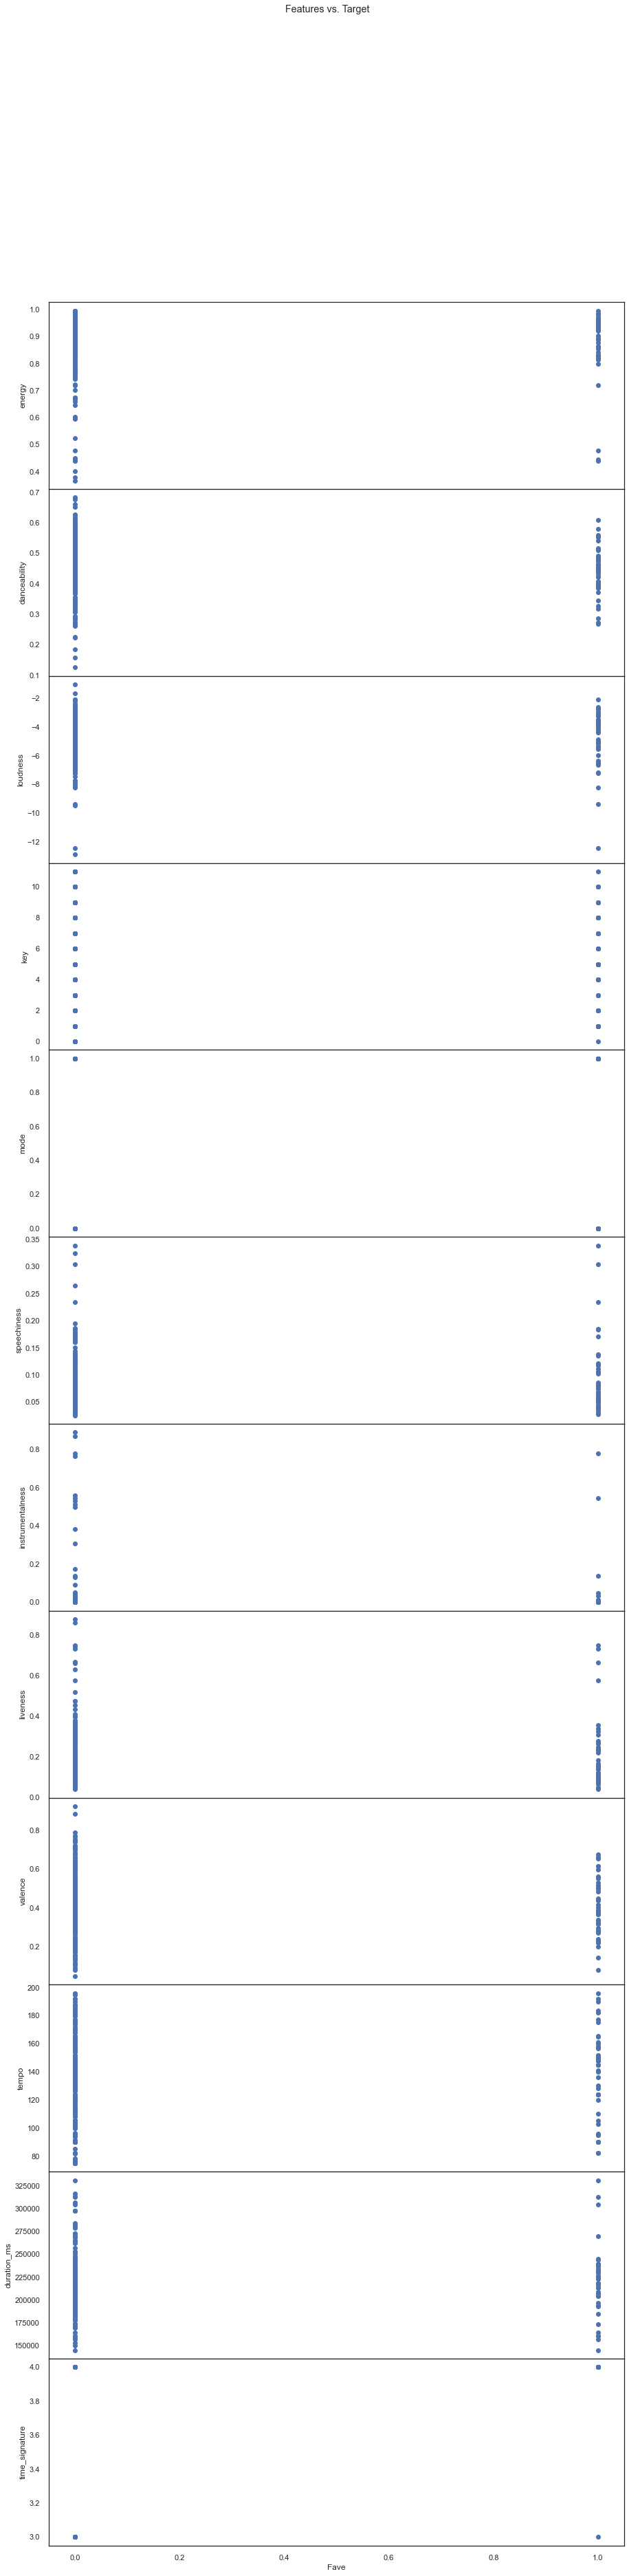

In [12]:
import statistics as st
import matplotlib.pyplot as plt
import numpy as np

#code for stratifiation of independent variables by the target variable
fig, axs = plt.subplots(12, sharex=True, gridspec_kw={'hspace': 0}, figsize=(15,60))
fig.suptitle('Features vs. Target')
axs[0].scatter(df['Fave'], df['energy'])
axs[0].set(ylabel='energy')
axs[1].scatter(df['Fave'], df['danceability'])
axs[1].set(ylabel='danceability')
axs[2].scatter(df['Fave'], df['loudness'])
axs[2].set(ylabel='loudness')
axs[3].scatter(df['Fave'], df['key'])
axs[3].set(ylabel='key')
axs[4].scatter(df['Fave'], df['mode'])
axs[4].set(ylabel='mode')
axs[5].scatter(df['Fave'], df['speechiness'])
axs[5].set(ylabel='speechiness')
axs[6].scatter(df['Fave'], df['instrumentalness'])
axs[6].set(ylabel='instrumentalness')
axs[7].scatter(df['Fave'], df['liveness'])
axs[7].set(ylabel='liveness')
axs[8].scatter(df['Fave'], df['valence'])
axs[8].set(ylabel='valence')
axs[9].scatter(df['Fave'], df['tempo'])
axs[9].set(ylabel='tempo')
axs[10].scatter(df['Fave'], df['duration_ms'])
axs[10].set(ylabel='duration_ms')
axs[11].scatter(df['Fave'], df['time_signature'])
axs[11].set(ylabel='time_signature')

for ax in axs:
    ax.label_outer()
    
for ax in axs.flat:
    ax.set(xlabel='Fave')

From these plots, it can be seen that the majority of the outcomes from Fave are '0' which is not 'like'. No other large patterns between the variables are detected from these plots.


### Data Transformations

Due to skewed distributions that were revealed above, the below variables were transformed:

* Speechiness: Speechiness was right skewed. A simple sqrt transformation was performed.
* Liveness: Liveness was right skewed. A simple log function was performed.
* Energy: Energy was heavily left skewed. Utilizing a square root transformation was performed.
* Loudness: Loudness was left skewed. An absolute value transformation was paired with a natural log was performed.

Before computing the transformations, additional work was done to change the values to remove '0' values in the data, as this would result in missing errors. For example, when computing natural log, a value of 0 results in infinity.

In [13]:
import numpy as np

#code for transformation
df['speechiness'] = [1 + df.speechiness[i] for i in range(len(df))]
df['speechiness'] = [np.sqrt(df.speechiness[i]) for i in range(len(df))]
df['liveness'] = [1 + df.liveness[i] for i in range(len(df))]
df['liveness'] = [np.log(df.liveness[i]) for i in range(len(df))] 
df['energy'] = [1 - df.energy[i] for i in range(len(df))]
df['energy'] = [np.sqrt(df.energy[i]) for i in range(len(df))]
df['loudness'] = [1 + np.absolute(df.loudness[i]) for i in range(len(df))]
df['loudness'] = [np.log(df.loudness[i]) for i in range(len(df))]
df['instrumentalness'] = [1 + df.instrumentalness[i] for i in range(len(df))]
df['instrumentalness'] = [np.log(df.instrumentalness[i]) for i in range(len(df))]

In [14]:
from scipy import stats
z = np.abs(stats.zscore(df['instrumentalness']))
threshold = 3
instoutliers = np.where(z > 3)
type(instoutliers)
instoutliers = list(instoutliers)
instoutliers
df = df.drop([ 24,  37,  66, 119, 121, 125, 130, 195, 204, 215, 236])

In [15]:
#interactive histograms
plyo.init_notebook_mode() 
plyo.iplot( 
    df[["danceability","energy","key","loudness","mode","speechiness","instrumentalness","liveness","valence","tempo", "duration_ms", "time_signature"]].iplot(asFigure=True 
                                          ,kind='hist' 
                                          ,subplots=True 
                                          ,bins=10)) 


Given the above distributions, I have decided to remove specific independent variables from the predictive model where skewed distributions are still seen despite transformation efforts to normalize the data. The variables that will be removed include:

- instrumentalness
- mode
- duration_ms
- time_signature

Please note, the latter two variables will be removed as knowing the subject area, the time of a track does not influence whether it will be labelled as a fave or not. The length of a track has little bearing on enjoyment

## Predictive Classification Model

Next, I will create a k-Nearest Neighbors (k-NN) model using the Spotify data to make predictions on new unseen data. A test will be performed with new data once the model has been trained and tested, and accuracy of the model has been evaluated.

In [16]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

### Modeling with k-Nearest Neighbors (k-NN)

In [17]:
#setting target and features for the model
df = df[["Fave", "danceability", "energy", "loudness", "speechiness", "valence", "tempo", "key","liveness"]]
target = "Fave"
features = list(df.columns)
features.remove('Fave')
X = df[features]
y = df[target]

#test size set to 0.5 for the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

As the dataset is fairly small at 250 rows, I went with a larger than default test size of 0.5 to ensure there was sufficient data to train and test on. Ideally, there would be a larger dataset to work with. 

In [18]:
#knn model
knn = KNeighborsClassifier(n_neighbors=3)
# Fit the model using the two training datasets
knn.fit(X_train, y_train)   


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [19]:
# Get the training score of the model
knn.score(X_train, y_train)  

0.8403361344537815

This accuracy score of 84% is for the model while training. Given this is not much higher than the accuracy score for the test dataset, it would suggest that it did not overfit.

In [20]:
# Get the test score of the model
knn.score(X_test, y_test) 

0.775

A score of 77.5% has been achieved for the test.


#### Additional Accuracy Measures

In [21]:
import math
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error

# Make predictions against the test set
pred = knn.predict(X_test)

#accuracy and error measures
score = explained_variance_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = math.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
    
print("score = {:.5f} | MAE = {:.3f} | RMSE = {:.3f} | R2 = {:.5f}"
          .format(score, mae, rmse, r2)) 

score = -0.73802 | MAE = 0.225 | RMSE = 0.474 | R2 = -0.76471


The high explained variance score is fairly high indicating a stronger strength of association which should make better predictions.  

The mean absolute error of 0.225 is showing the average magnitude of the errors in the set of forecasts, without considering their direction.

Root mean square error of this model if 0.474 which is the error of the model in making predictions. 

R-squared value is -0.76 for the percentage of variation in the dependent variable that's explained by independent variables in the model.

#### Confusion Matrix

Next, I will be making predictions against the test set and looking at the confusion matrix as well as several accuracy measures against the true classes.

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, classification_report

# Show the confusion matrix
print("confusion matrix:")
print(confusion_matrix(y_test, pred))

# Find the accuracy scores of the predictions against the true classes
print("accuracy: %0.3f" % accuracy_score(y_test, pred))
print("recall: %0.3f" % recall_score(y_test, pred))
print("precision: %0.3f" % precision_score(y_test, pred))
print("f-measure: %0.3f" % fbeta_score(y_test, pred, beta=1))
print(classification_report(y_test,pred))


confusion matrix:
[[92 10]
 [17  1]]
accuracy: 0.775
recall: 0.056
precision: 0.091
f-measure: 0.069
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       102
           1       0.09      0.06      0.07        18

    accuracy                           0.78       120
   macro avg       0.47      0.48      0.47       120
weighted avg       0.73      0.78      0.75       120



The confusion matrix is showing the over accuracy as mentioned above for 77.5% with a clear breakdown against the true classes. The TP predictions seem high which is promising however, there are a large number of FPs. Please see the full breakdown explanation below.

- True Positive (TP): is 92 where a positive observation, and is predicted to be positive.
- False Negative (FN): is 10 where an Observation is positive but is predicted negative.
- True Negative (TN): is 1 where an observation is negative and is predicted to be negative.
- False Positive (FP): is 17 where an observation is negative but is predicted positive.

Recall is showing 0.056. The low recall indicates the class is incorrectly recognized which is shown by the high FPs and FNs. 

Precision is also low at 0.091. This is slightly higher than recall but still not much confidence to indicate an example labeled as positive is indeed positive. The model does have a high number of FPs.

As the precision number of lower than the high recall number overall this shows that most of the positive examples are correctly recognized (low FN) but there are a lot of false positives

F-measure at 0.069 is also low. 


# Model Summary & New Prediction

In general, the k-NN model has good accuracy but with the predictions it makes, it does result in high FPs. This could be due to the dataset size and possibly requiring more observations to train and test the model.

I will be moving forward with using this model for making predictions on new unseen data. 

A flask application will be created, and some test criteria will be used to make a new prediction. The new prediction will be for the below:
- danceability = 0.
- energy = 0.87
- loudness = -4.60
- speechiness = 0.08
- valence = 0.43
- tempo = 135.10
- key 5.07
- liveness - 0.21


As the data was transformed for some variables to leverage into the model, I will need to transform some of the above test values that are in the original scale.  The below set of code achieves this.

In [23]:
import numpy as np

#values for transformed variables are handled
energy = [1 - 0.87]
energy_transformed = [np.sqrt(energy)]
energy_transformed

[array([0.36055513])]

In [24]:
loudness = [1 + np.absolute(-4.60)]
loudness_transformed = [np.log(loudness)]
loudness_transformed

[array([1.7227666])]

In [25]:
speechiness= [1 + 0.08]
speechiness_transformed = [np.sqrt(speechiness)]
speechiness_transformed

[array([1.03923048])]

In [26]:
liveness  = [1 + - 0.21]
liveness_transformed = [np.log(liveness)] 
liveness_transformed

[array([-0.23572233])]

The final set of values to use within the flask application will be:

* danceability = 0.3
* energy = 0.36
* loudness = 1.72
* speechiness = 1.039
* valence = 0.43
* tempo = 135.10
* key 5.07
* liveness -0.2357

## Serialization of Code for Flask Application

Now that I'm ready to test the model on new unseen data for the specific criteria outlined above, I need to write to prepare for the flask application by writing to a pickle file and serializing the data.

The directory that I'm using is a data folder withiin the working directory.

In [27]:
import joblib

#Open with to serialize the data
#dump to put the data in a pickle file
with open("data/classificationModel.pkl", "wb") as fwb:
    joblib.dump(knn, fwb)
    

## Flask Application Corresponding Files

There is a corresponding app.py file that I will use for the flask application in order to make the prediction in Postman. The file structure used is lib/models/classificationModel.pkl and opened using Sypder (Anadona).


## Postman Application

The app.py file will need to be run and remain open at the same time as using Postman.

The test track parameters from above were entered into Postman and the below HTML sting from Postman can be used to display the test classficiation prediction. : 
http://0.0.0.0:5000/classification?danceability=.3&energy=0.36&loudness=1.72&speechiness=1.039&valence=0.43&tempo=135.10&key=5.07&liveness=-0.2357

# Final Test Result
The classification prediction provides either a label for '1' or '0' ('Like' or not 'Like'). The output of this test track scenario is **0**, meaning the Spotify user **will not 'like'** this particular track. 